Elapsed time of data splitting stage: 13.9674 seconds
Epoch 1/10, Loss: 0.6909395456314087
Epoch 2/10, Loss: 0.6190685033798218
Epoch 3/10, Loss: 0.5299897789955139
Epoch 4/10, Loss: 0.4306415021419525
Epoch 5/10, Loss: 0.34812596440315247
Epoch 6/10, Loss: 0.29848629236221313
Epoch 7/10, Loss: 0.2717186510562897
Epoch 8/10, Loss: 0.24913060665130615
Epoch 9/10, Loss: 0.22215834259986877
Epoch 10/10, Loss: 0.19834941625595093
Test Accuracy: 0.9845
[[ 87937   1477]
 [  1780 118521]]
              precision    recall  f1-score   support

           0     0.9802    0.9835    0.9818     89414
           1     0.9877    0.9852    0.9864    120301

    accuracy                         0.9845    209715
   macro avg     0.9839    0.9843    0.9841    209715
weighted avg     0.9845    0.9845    0.9845    209715

Elapsed time of training stage: 5.8336 seconds
Test Accuracy (Adversarial): 0.5592
Epsilon Strength: 1
[[89405     9]
 [92441 27860]]
              precision    recall  f1-score   suppor

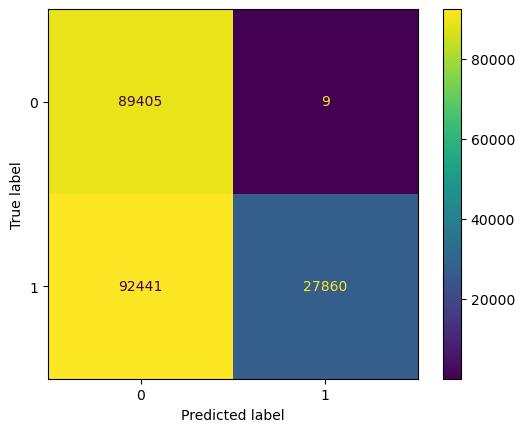

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay 
import time  # Import the time module

# Record the start time
start_time = time.time()

# Reads the csv dataset file into pandas.
dataset_path = 'out.csv'
df = pd.read_csv(dataset_path)
# Assigns csv to dataframe

# I had to remove the Timestamp column from the dataset and remove the repeated columns values that appeared
# in the file at 1000001. Did this manually but will add preprocessing to check and remove those values.
# Will add in the specific rows of data removed where column labels were repeated and therefore deleted
# with which dataset file this was done in.

# Removes missing values and works within the dataframe doesn't make a new one with.
df.dropna(inplace=True)

# Separates the attacks into a separate list to use for training and testing purposes.
X = df.drop(columns=['Label'])
y = df['Label']
# Sets y as the label column for splitting.

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# Splits dataset into trainng and testing features and training and testing true classes, 80/20 split. random_state=42

# Standardising the data to make training quicker and lower the chance of it breaking from outliers.
scaler = StandardScaler()
# Sets scaler to sklearn StandardScaler() function.
X_train_scaled = scaler.fit_transform(X_train)
# Fits and then transforms the data with StandardScaler.
X_test_scaled = scaler.transform(X_test)
# Performs standardization by centering and scaling.

# Converts to integers 0 for benign, 1 for attack
y_train_slow = (y_train == 'DoS attacks-SlowHTTPTest').astype(int)
y_train_hulk = (y_train == 'DoS attacks-Hulk').astype(int)
y_train = y_train_slow.combine(y_train_hulk, max)
# Combines the two numpy arrays using an OR gate for the highest value.

# Converts to integers 0 for benign, 1 for attack
y_test_slow = (y_test == 'DoS attacks-SlowHTTPTest').astype(int)
y_test_hulk = (y_test == 'DoS attacks-Hulk').astype(int)
y_test = y_test_slow.combine(y_test_hulk, max)
# Combines the two numpy arrays using an OR gate for the highest value.

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time of data splitting stage: {elapsed_time:.4f} seconds")

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Record the start time
start_time = time.time()

# Simple neural network model.
class IntrusionDetectionModel(nn.Module):
    def __init__(self, input_size):
        super(IntrusionDetectionModel, self).__init__()
        # Input later uses the size of the input which in my case is 78 features.
        self.fc1 = nn.Linear(input_size, 64)
        #Fully connected layers that apply linear transformations.
        self.fc2 = nn.Linear(64, 32)
        # 64 nodes to 32.
        self.dropout2 = nn.Dropout(0.2)  # Add dropout layer with 20% dropout rate.
        self.fc3 = nn.Linear(32, 16)
        # 32 nodes to 16.
        self.dropout3 = nn.Dropout(0.2)  # Add dropout layer with 20% dropout rate.
        self.fc4 = nn.Linear(16, 1)
        # Final fully connected layer with one output.
        self.sigmoid = nn.Sigmoid()
        # Sigmoid function is applied maping the output a number between 0-1 for classification.

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        # Applies the Rectified Linear Activation Function to the output of the first layer. Same thing repeated.
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)  # Apply dropout after the second layer
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)  # Apply dropout after the third layer
        x = self.fc4(x)
        # Computes the output of the final fully connected layer.
        return self.sigmoid(x)
        # Applies Sigmoid function and returns the output.

input_size = X_train.shape[1]
# Sets intput size to shape of features inputted into the model.
model = IntrusionDetectionModel(input_size)
# Initializing the model with the input size passed as the variable.

# Loss function and optimizer
criterion = nn.BCELoss()
# Sets criterion to binary cross-entropy loss used for binary classification tasks.
optimizer = optim.Adam(model.parameters(), lr=0.01)
# Optimizer initialised using the Adam algorithm with the learning weight of 0.01

# Training the model.
epochs = 10
# Epochs set as the number of iterations for the training.
for epoch in range(epochs):
    # For loop iterating through epochs given.
    optimizer.zero_grad()
    # Gradients set to zero for every iteration as they are individual to the instance of model learning at the time.
    outputs = model(torch.FloatTensor(X_train_scaled))
    # the model's output predications are computed for the scaled training data.
    loss = criterion(outputs, torch.FloatTensor(y_train.values).unsqueeze(1))
    # The BCELoss is calculated between the predictions and the one-hot encoded classes.
    loss.backward()
    # Gradients are computed using backpropogation
    optimizer.step()
    # Model parameters are updated using the optimizer.
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")
    # Prints the loss value of the current epoch.

# Evaluating the model based on the test data made with the original dataset
with torch.no_grad():
    test_outputs = model(torch.FloatTensor(X_test_scaled))
    predicted_labels = (test_outputs >= 0.5).squeeze().numpy()
    accuracy = accuracy_score(y_test, predicted_labels)
    print(f"Test Accuracy: {accuracy:.4f}")
    print(confusion_matrix(y_test, predicted_labels))
    print(classification_report(y_test, predicted_labels, digits=4))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time of training stage: {elapsed_time:.4f} seconds")


# Record the start time
start_time = time.time()

from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier
# Imports necassary libraries for the attack.

# Creates a PyTorch classifier using the trained model.
classifier = PyTorchClassifier(
    model=model,
    loss=criterion,
    optimizer=optimizer,
    input_shape=(input_size),
    nb_classes=2,  # Binary classification
)

# X_test_scaled is a numpy array but .dtype float64 needs to be float32
X_test_scaled_tensor = torch.FloatTensor(X_test_scaled)
# ndarray passed to tensor, stored as float32.
x_test_nump = X_test_scaled_tensor.numpy()
# Turned back into a ndarray, .astype does not let me change it to float32.

fgm_attack = FastGradientMethod(estimator=classifier, eps=1)
# Initialises the Fast Gradient Method attack with epsilon strength.

X_test_adv = fgm_attack.generate(x=x_test_nump)
# Generates Adversarial test dataset.

# Same evaluation as the model training. evaluation
with torch.no_grad():
    test_outputs_adv = model(torch.FloatTensor(X_test_adv))
    predicted_labels_adv = (test_outputs_adv >= 0.5).squeeze().numpy()
    accuracy_adv = accuracy_score(y_test, predicted_labels_adv)
    print(f"Test Accuracy (Adversarial): {accuracy_adv:.4f}")
    print("Epsilon Strength: 1")
    cm = confusion_matrix(y_test, predicted_labels_adv)
    print(cm)
    print(classification_report(y_test, predicted_labels_adv, digits=4))

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time of Adversarial Stage: {elapsed_time:.4f} seconds")

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
cm_display.plot()
plt.savefig("cm")